# Synthetic Experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader


from models.NormalizingFlowFactories import buildFCNormalizingFlow, buildFixedFCNormalizingFlow
from models.Conditionners import DAGConditioner, StrAFConditioner
from models.Normalizers import AffineNormalizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utils

In [3]:
from plot_utils import plot_gmm

def viz_data(data, bounds=2):
    f, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].scatter(data[:, 0], data[:, 1], alpha=0.5, s=2)
    ax[0].set_xlabel("X0")
    ax[0].set_ylabel("X1")
    ax[0].set_ylim(-bounds, bounds)
    ax[0].set_xlim(-bounds, bounds)
    ax[1].scatter(data[:, 0], data[:, 2], alpha=0.5, s=2)
    ax[1].set_xlabel("X0")
    ax[1].set_ylabel("X2")
    ax[1].set_ylim(-bounds, bounds)
    ax[1].set_xlim(-bounds, bounds)
    ax[2].scatter(data[:, 1], data[:, 2], alpha=0.5, s=2)
    ax[2].set_xlabel("X1")
    ax[2].set_ylabel("X2")
    ax[2].set_ylim(-bounds, bounds)
    ax[2].set_xlim(-bounds, bounds)
    f.tight_layout()
    plt.show()

def viz_err(pred, true, ax):
    bounds = 8
    f, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    d1 = pred[:, 0]
    d2 = pred[:, 1]
    d3 = pred[:, 2]

    plot_gmm(ax[0], true[:, 0:2], bounds=[-bounds, bounds, -bounds, bounds], n_comp=6)
    ax[0].scatter(d1, d2, s=4, alpha=0.5, label="Samples", c='k')
    ax[0].legend()
    ax[0].set_xlabel("X0")
    ax[0].set_ylabel("X1")
    ax[0].set_ylim(-bounds, bounds)
    ax[0].set_xlim(-bounds, bounds)
    
    plot_gmm(ax[1], true[:, [0, 2]], bounds=[-bounds, bounds, -bounds, bounds], n_comp=8)
    ax[1].scatter(d1, d3, s=4, alpha=0.5, label="Samples", c='k')
    ax[1].legend()
    ax[1].set_xlabel("X0")
    ax[1].set_ylabel("X2")
    ax[1].set_ylim(-bounds, bounds)
    ax[1].set_xlim(-bounds, bounds)
    
    plot_gmm(ax[2], true[:, 1:3], bounds=[-bounds, bounds, -bounds, bounds], n_comp=10)
    ax[2].scatter(d2, d3, s=4, alpha=0.5, label="Samples", c='k')
    ax[2].legend()
    ax[2].set_xlabel("X1")
    ax[2].set_ylabel("X2")
    ax[2].set_ylim(-bounds, bounds)
    ax[2].set_xlim(-bounds, bounds)
    

## Data Generation

In [4]:
def generate_3d_synth(n_samp, scale=1):
    d1 =  np.random.normal(size=n_samp, scale=scale)
    d2 =  2 * d1 * np.random.normal(size=n_samp, scale=scale)
    d3 =  -2 * d1 + np.random.normal(size=n_samp, scale=scale)

    return np.vstack([d1, d2, d3]).T

def generate_3d_synth_t(n_samp, scale=1):
    d1 =  np.random.normal(size=n_samp, scale=scale) + 1
    d2 =  2 * d1 * np.random.normal(size=n_samp, scale=scale)
    d3 =  -2 * d1 * np.random.normal(size=n_samp, scale=scale)

    return np.vstack([d1, d2, d3]).T

def generate_3d_synth_bin(n_samp, p=0.95):
    d1 = np.random.normal(size=n_samp) * np.random.binomial(1, p, size=n_samp)
    d2 = d1 * np.random.normal(size=n_samp) #* np.random.binomial(1, p, size=n_samp) 
    d3 = d2 * np.random.normal(size=n_samp)

    return np.vstack([d1, d2, d3]).T

def normalize(data):
#     mean = np.mean(data, axis=0)
#     std = np.std(data, axis=0)
#     data = (data - mean) / std

#     data_std = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
#     data = data_std * (2) - 1

    return data

gen_fn = generate_3d_synth

train_data = normalize(gen_fn(20000))
val_data = normalize(gen_fn(2000))
test_data = normalize(gen_fn(1000))
true_dist = normalize(gen_fn(10000))

true_A = [
    [0, 0, 0],
    [1, 0, 0],
    [1, 0, 0],
]

true_A = torch.Tensor(true_A).to(device)

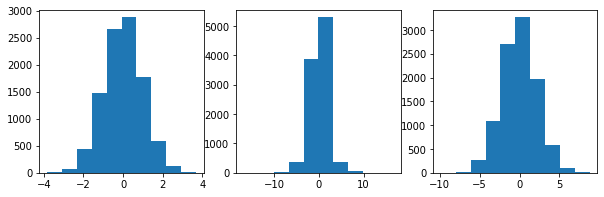

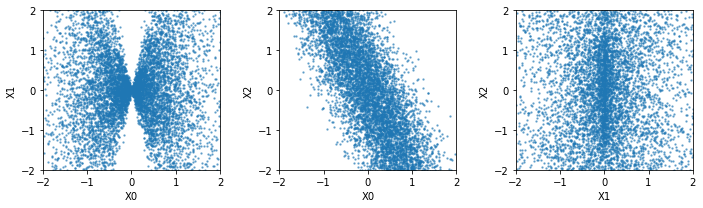

In [5]:
f, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].hist(true_dist[:, 0])
ax[1].hist(true_dist[:, 1])
ax[2].hist(true_dist[:, 2])
plt.show()
viz_data(true_dist)

## StrAF Model

In [6]:
straf_emb_net = [50] * 3 + [2]
straf_n_flows = 5

conditioner_type = StrAFConditioner
conditioner_args = {
    "in_size": train_data.shape[1],
    "hidden": straf_emb_net[:-1],
    "out_size": straf_emb_net[-1],
    "adjacency": true_A,
    "device": device
}

normalizer_type = AffineNormalizer
normalizer_args = {}

straf_model = buildFixedFCNormalizingFlow(straf_n_flows, conditioner_type, conditioner_args, 
                                          normalizer_type, normalizer_args)
straf_model.to(device)
straf_opt = torch.optim.Adam(straf_model.parameters(), 1e-4, weight_decay=1e-5)

6.872450828552246 7.07443904876709
6.173940658569336 6.34283447265625
5.77288293838501 5.9205002784729
5.51200532913208 5.645293235778809
5.33283805847168 5.456216335296631
5.204152584075928 5.319889545440674
5.108039379119873 5.217187881469727
5.031517505645752 5.134894371032715
4.966370105743408 5.065158367156982
4.908545017242432 5.004033088684082


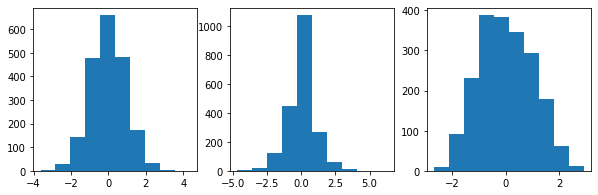

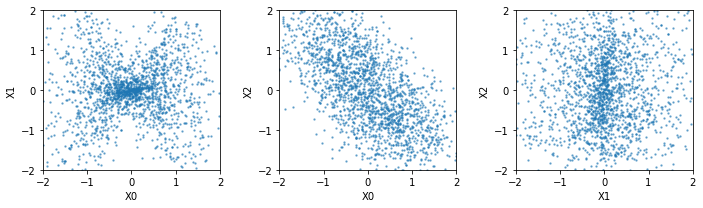

4.854861259460449 4.9486165046691895
4.8047966957092285 4.897256374359131
4.757653713226318 4.849059581756592
4.713749408721924 4.80423641204834
4.674387454986572 4.764037132263184
4.641347408294678 4.729765892028809
4.613960266113281 4.700640678405762
4.590803623199463 4.676000595092773
4.57130765914917 4.655216217041016
4.55436897277832 4.637453079223633


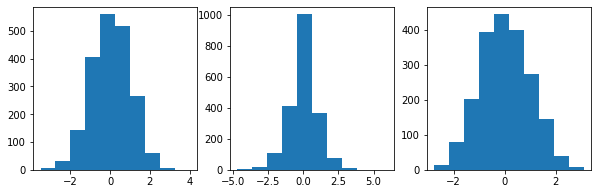

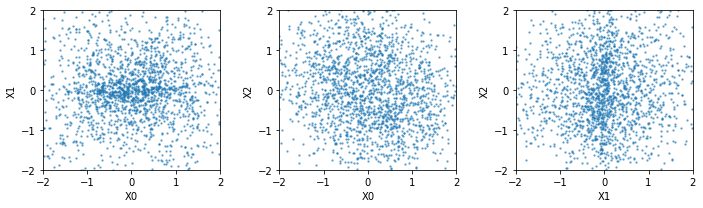

4.5393900871276855 4.621130466461182
4.526473045349121 4.607779502868652
4.5149617195129395 4.596330165863037
4.504870414733887 4.5858354568481445
4.495631694793701 4.576251029968262
4.486838340759277 4.567134857177734
4.478938579559326 4.558618545532227
4.471408367156982 4.5504961013793945
4.464446544647217 4.542914390563965
4.458020210266113 4.535412311553955


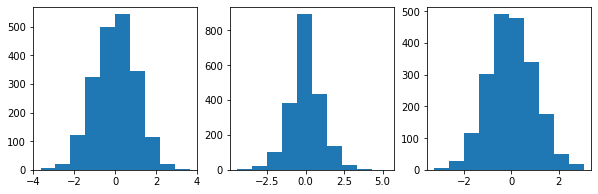

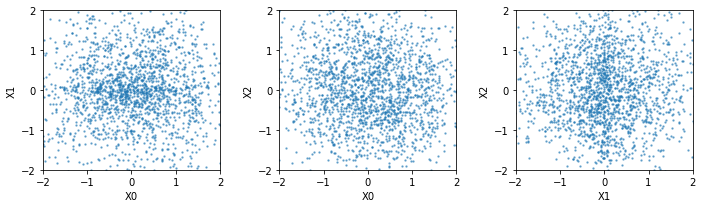

4.451637268066406 4.528045177459717
4.445657253265381 4.520868301391602
4.439951419830322 4.513922691345215
4.43425178527832 4.507227420806885
4.428600788116455 4.500685691833496
4.423008441925049 4.49448299407959
4.417662620544434 4.488431930541992
4.412364482879639 4.4825119972229
4.407073497772217 4.476751327514648
4.401828765869141 4.471078395843506


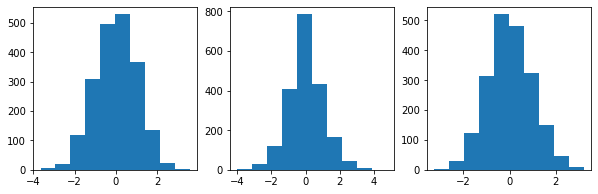

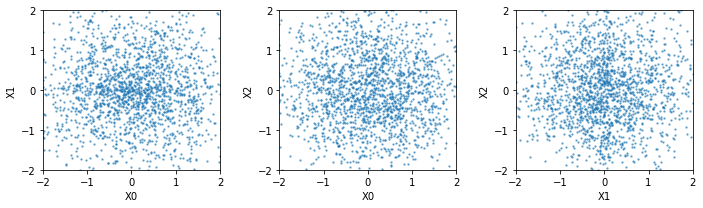

4.396697998046875 4.465577125549316
4.39159631729126 4.460203170776367
4.386481761932373 4.454984664916992
4.381191730499268 4.449958801269531
4.375801086425781 4.445015907287598
4.370692729949951 4.440262317657471
4.36564302444458 4.435609817504883
4.360787868499756 4.431161403656006
4.35598087310791 4.426918029785156
4.351180076599121 4.42284631729126


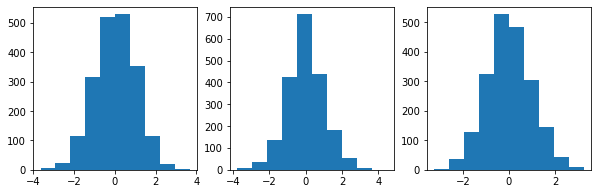

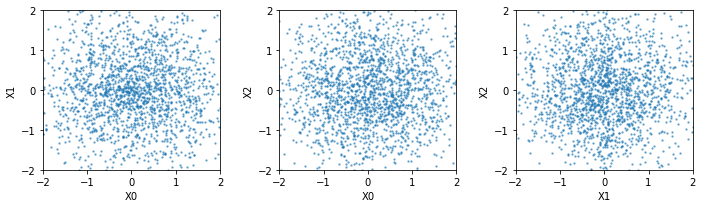

4.346468925476074 4.418878555297852
4.341892719268799 4.415074348449707
4.337332248687744 4.411355495452881
4.33306360244751 4.407702922821045
4.328939914703369 4.4041643142700195
4.324916839599609 4.400724411010742
4.321057319641113 4.3974080085754395
4.317279815673828 4.394252777099609
4.31356143951416 4.391200542449951
4.309937477111816 4.388245582580566


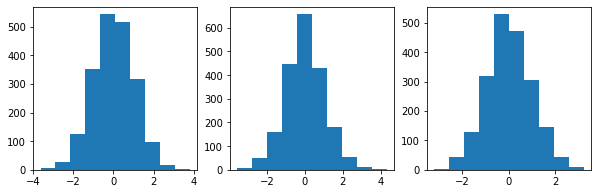

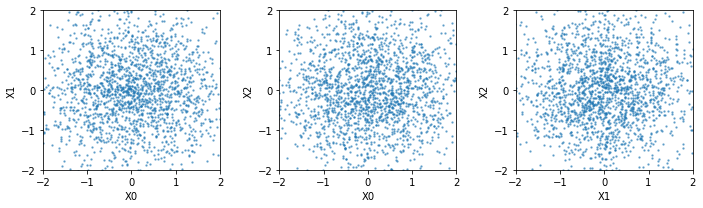

4.306328773498535 4.385372161865234
4.303048610687256 4.382561206817627
4.299784183502197 4.3799262046813965
4.2965617179870605 4.377396583557129
4.29335880279541 4.374927043914795
4.290276050567627 4.372575283050537
4.28723669052124 4.370298385620117
4.284397602081299 4.368102550506592
4.281689643859863 4.365972995758057
4.279002666473389 4.363941669464111


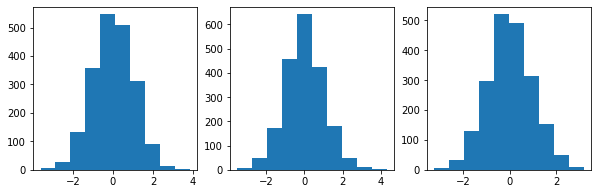

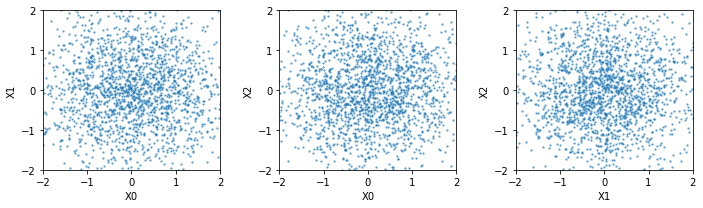

4.276406764984131 4.361993312835693
4.273983001708984 4.3600873947143555
4.271618843078613 4.358318328857422
4.269318580627441 4.356601715087891
4.267125606536865 4.354959011077881
4.265038967132568 4.353425025939941
4.263028621673584 4.352005481719971
4.261116027832031 4.350687503814697
4.259281635284424 4.3494110107421875
4.257544040679932 4.348229885101318


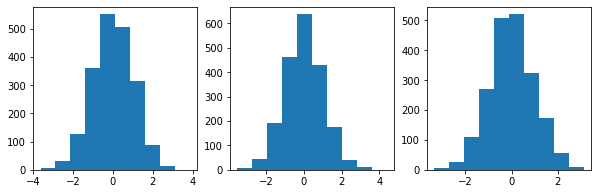

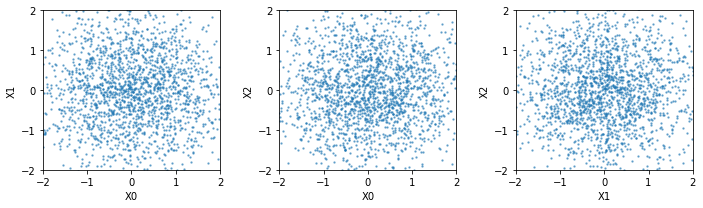

4.2558817863464355 4.3471150398254395
4.254291534423828 4.346031188964844
4.25275182723999 4.345029354095459
4.251312255859375 4.344100475311279
4.249902248382568 4.343155384063721
4.248610496520996 4.342245578765869
4.247387886047363 4.341373443603516
4.246170997619629 4.340569496154785
4.245120525360107 4.339779376983643
4.244134426116943 4.339069843292236


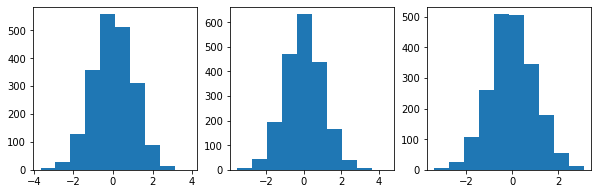

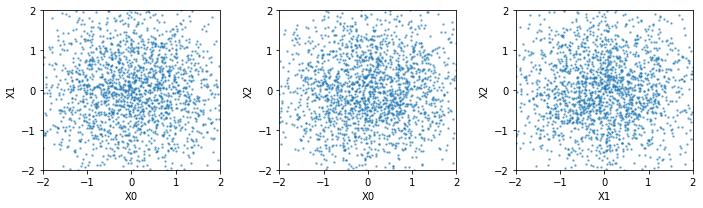

4.243182182312012 4.338406562805176
4.242276191711426 4.337741374969482
4.241421699523926 4.337107181549072
4.2405805587768555 4.33650541305542
4.239747047424316 4.335929870605469
4.2390289306640625 4.335341453552246
4.238305568695068 4.3347930908203125
4.237613677978516 4.334298133850098
4.236959934234619 4.333798408508301
4.23633337020874 4.333275318145752


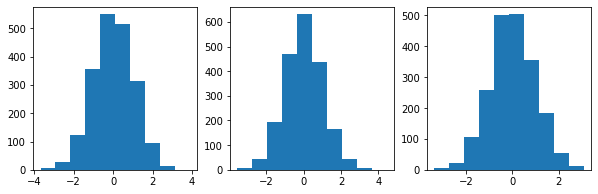

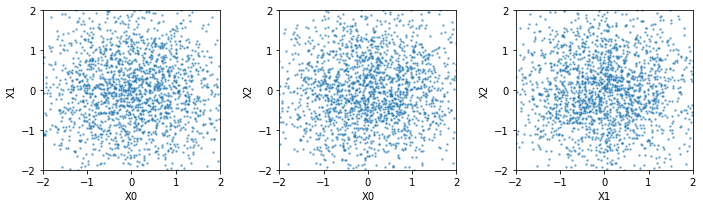

4.235743045806885 4.332747459411621
4.235130310058594 4.332278728485107
4.234546661376953 4.331814765930176
4.233964920043945 4.3313469886779785
4.233416557312012 4.330895900726318
4.232864856719971 4.3304643630981445
4.232325553894043 4.330049991607666
4.231822490692139 4.329660415649414
4.23130464553833 4.329281330108643
4.230832576751709 4.328899383544922


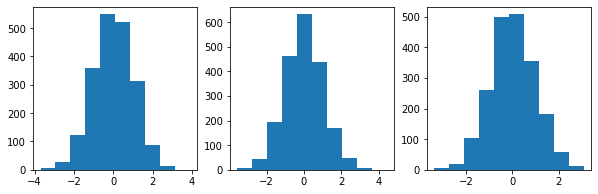

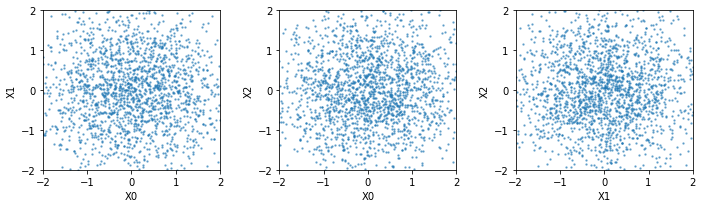

4.230342864990234 4.328485488891602
4.229865074157715 4.328064918518066
4.229382038116455 4.3276896476745605
4.228968143463135 4.327274799346924
4.2284746170043945 4.326902866363525
4.228059768676758 4.3265156745910645
4.227657794952393 4.326155662536621
4.2272539138793945 4.3258137702941895
4.226807117462158 4.32549524307251
4.22637939453125 4.325187683105469


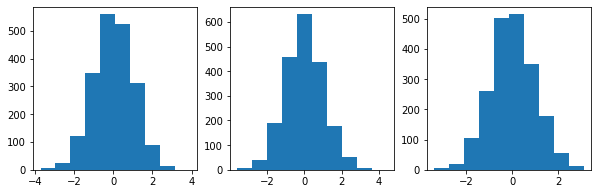

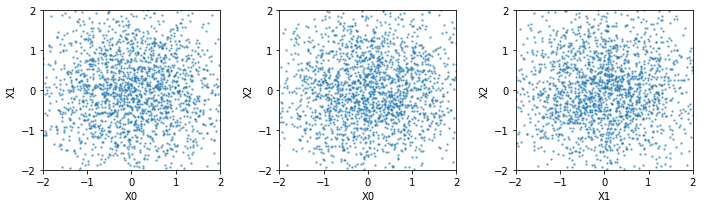

4.225993633270264 4.324854373931885
4.225590229034424 4.32457971572876
4.225224018096924 4.324289321899414
4.2249064445495605 4.324011325836182
4.224571704864502 4.323734760284424
4.22425651550293 4.323480606079102
4.223970890045166 4.32323694229126
4.223670482635498 4.322991847991943
4.223382472991943 4.322752475738525
4.223118782043457 4.322521686553955


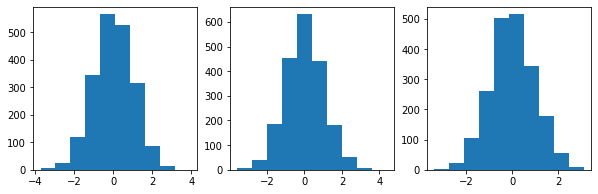

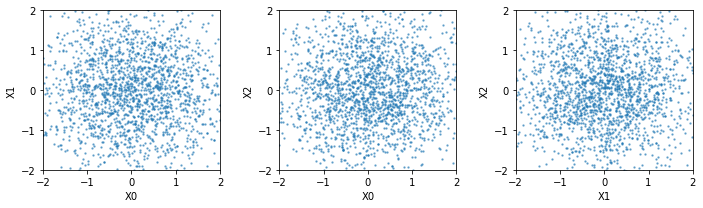

4.222879886627197 4.322265625
4.222612380981445 4.322027683258057
4.222286701202393 4.321815013885498
4.222027778625488 4.321582317352295
4.221766948699951 4.321356773376465
4.221505641937256 4.3211565017700195
4.221256732940674 4.3209357261657715
4.221034049987793 4.320724010467529
4.220789909362793 4.32051420211792
4.220555782318115 4.320311546325684


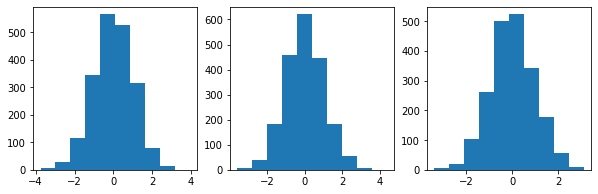

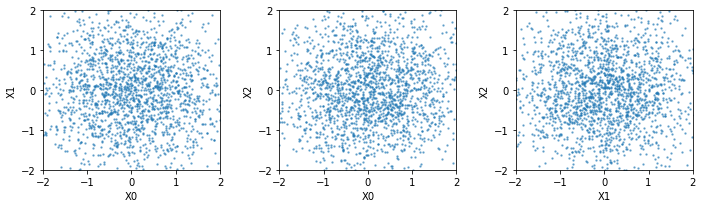

4.220320224761963 4.320099353790283
4.220094680786133 4.319889068603516
4.219885349273682 4.31970739364624
4.219683647155762 4.319488525390625
4.219471454620361 4.319301128387451
4.219269752502441 4.319128036499023
4.219074726104736 4.318961143493652
4.218891620635986 4.318796634674072
4.218700885772705 4.318613052368164
4.218554496765137 4.318419456481934


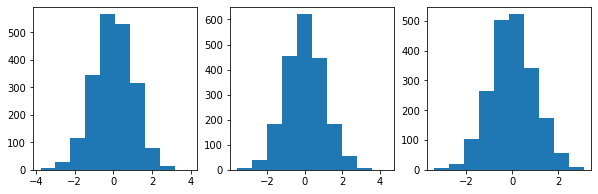

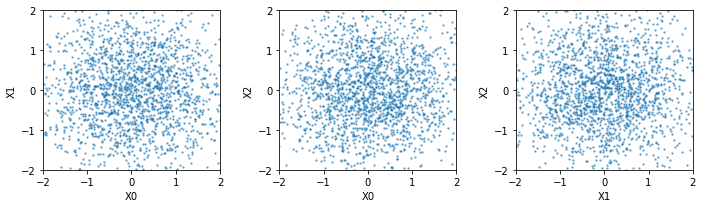

4.218371391296387 4.318244457244873
4.218157768249512 4.318088531494141
4.2179670333862305 4.317904949188232
4.217763423919678 4.317739009857178
4.217578887939453 4.317564964294434
4.217357635498047 4.317416191101074
4.217149257659912 4.317256450653076
4.216940402984619 4.317124366760254
4.216751575469971 4.316966533660889
4.216555595397949 4.316817760467529


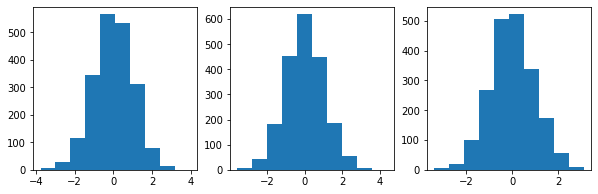

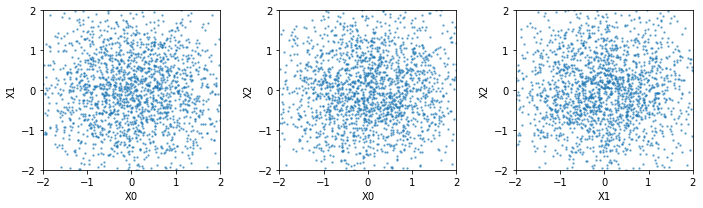

4.216353416442871 4.316669940948486
4.216172218322754 4.316500186920166
4.215976238250732 4.316361904144287
4.215768337249756 4.316227912902832
4.2155609130859375 4.316086292266846
4.215361595153809 4.315960884094238
4.215163707733154 4.315784454345703
4.214968681335449 4.31562614440918
4.21478271484375 4.315474033355713
4.21460485458374 4.315332889556885


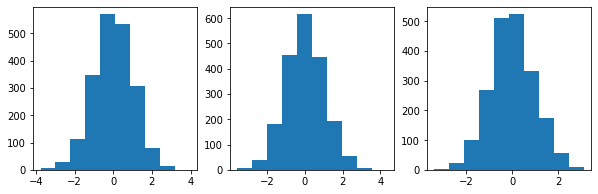

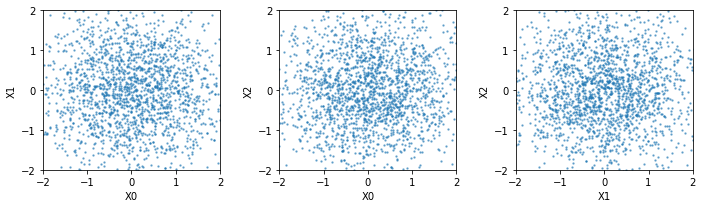

4.214413166046143 4.31519079208374
4.2142415046691895 4.315049171447754
4.21405553817749 4.314915180206299
4.213886737823486 4.3147735595703125
4.21373176574707 4.3146281242370605
4.213544845581055 4.31451940536499
4.213371753692627 4.314385890960693
4.21320915222168 4.314264297485352
4.213027000427246 4.314164161682129
4.212887763977051 4.314027786254883


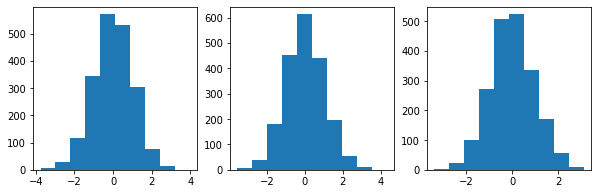

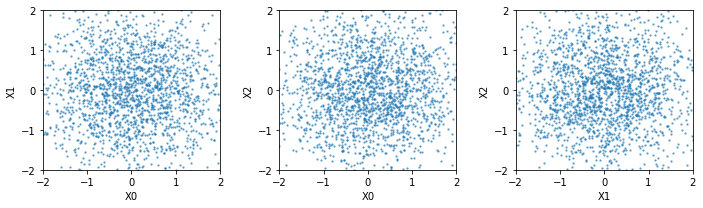

4.212691783905029 4.3139142990112305
4.212517261505127 4.313790321350098
4.212358474731445 4.313656330108643
4.212185382843018 4.31351375579834
4.211991786956787 4.313387870788574
4.211831569671631 4.3132805824279785
4.211646556854248 4.31318473815918
4.2114763259887695 4.313036918640137
4.2113165855407715 4.3129472732543945
4.211131572723389 4.312832355499268


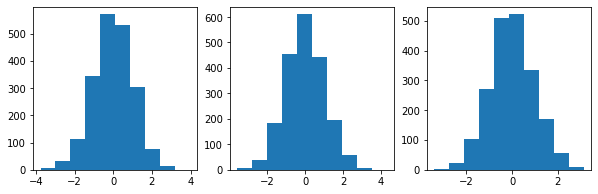

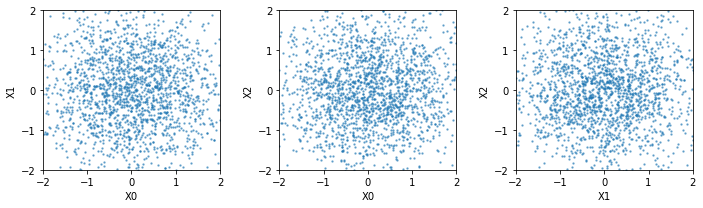

4.211019992828369 4.312718868255615
4.210854530334473 4.3126444816589355
4.210697650909424 4.312516212463379
4.210545539855957 4.312389373779297
4.210439205169678 4.312291622161865
4.210299491882324 4.312211990356445
4.210146903991699 4.312115669250488
4.210036277770996 4.3120198249816895
4.209903717041016 4.311924934387207
4.209811210632324 4.311826705932617


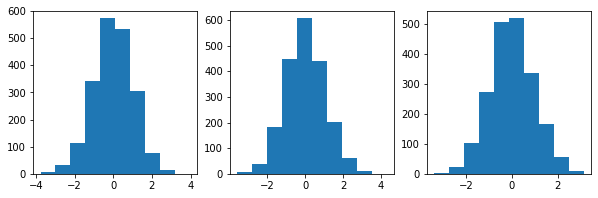

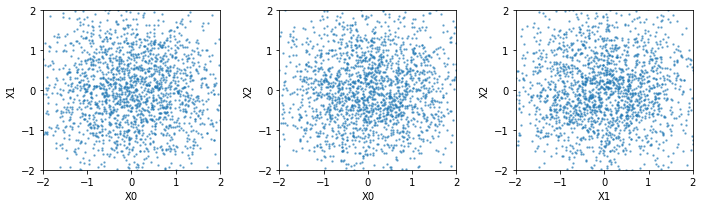

4.209711074829102 4.311731815338135
4.209612846374512 4.311644077301025
4.209503650665283 4.311586380004883
4.209390163421631 4.3114914894104
4.209301471710205 4.311400413513184
4.209220886230469 4.31130313873291
4.2091193199157715 4.311237335205078
4.209010601043701 4.3111162185668945
4.208905220031738 4.31107234954834
4.2087860107421875 4.310982704162598


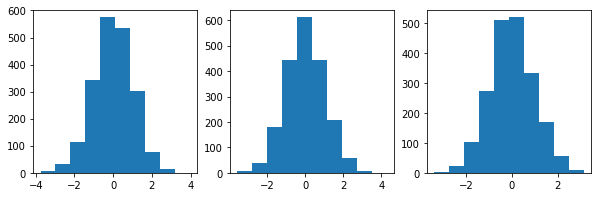

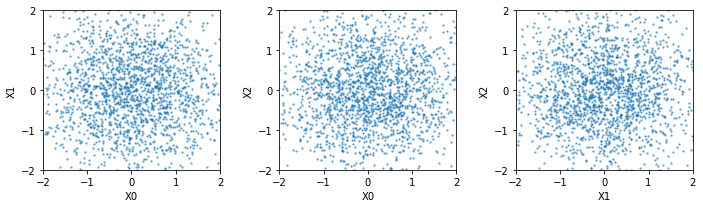

4.208711624145508 4.310939311981201
4.208603382110596 4.310867786407471
4.208532810211182 4.310813903808594
4.208443641662598 4.310765266418457
4.208360195159912 4.310730457305908
4.208271503448486 4.310676097869873
4.208183288574219 4.310628414154053
4.208130359649658 4.310585021972656
4.208057880401611 4.3105316162109375
4.207972049713135 4.310492515563965


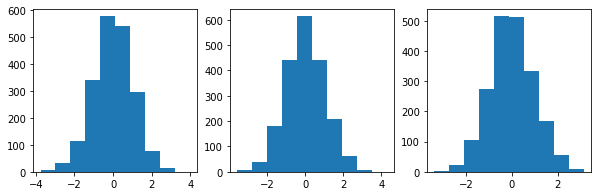

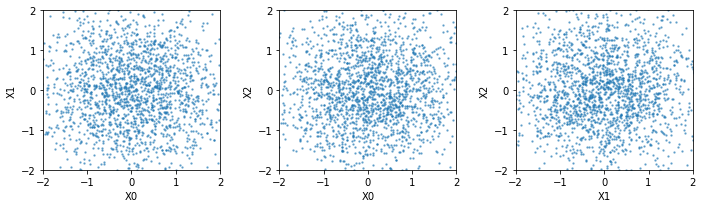

4.207878589630127 4.310455799102783
4.207791328430176 4.310393333435059
4.207743167877197 4.310352802276611
4.207661151885986 4.310299396514893
4.207605361938477 4.310245990753174
4.207546710968018 4.310222625732422
4.207477569580078 4.310143947601318
4.2074503898620605 4.31011438369751
4.207363128662109 4.310064792633057
4.207304954528809 4.310056686401367


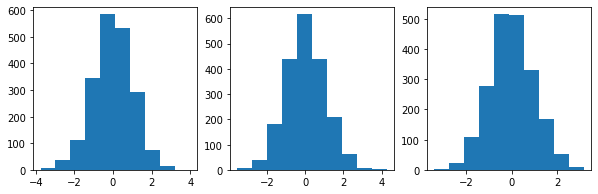

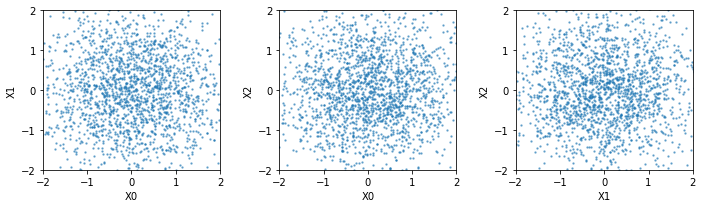

4.207232475280762 4.310030937194824
4.2071967124938965 4.309974670410156
4.207144260406494 4.309913158416748
4.207081317901611 4.309844493865967
4.2070465087890625 4.309834003448486
4.206981182098389 4.309787750244141
4.206978797912598 4.309779644012451
4.2069010734558105 4.309736728668213
4.206831455230713 4.309674263000488
4.2067694664001465 4.309651851654053


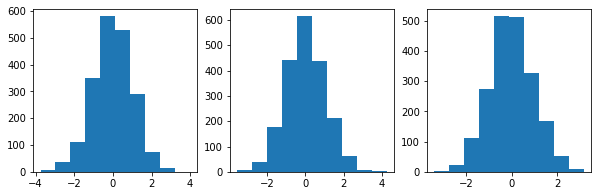

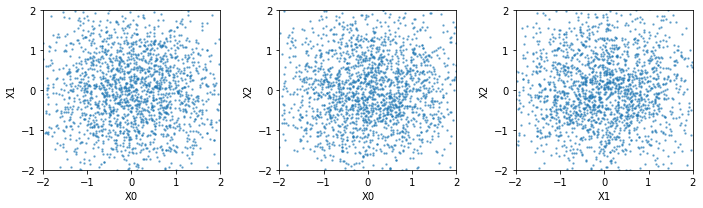

4.206716537475586 4.309607982635498
4.206675052642822 4.3095784187316895
4.206602096557617 4.309544086456299
4.206585884094238 4.309530735015869
4.206512451171875 4.309486389160156
4.2064714431762695 4.309433937072754
4.20641565322876 4.309442043304443
4.206361770629883 4.309360504150391
4.206308364868164 4.309380054473877
4.2062458992004395 4.309327125549316


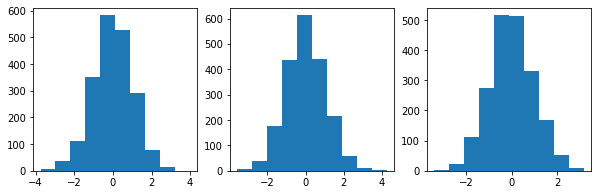

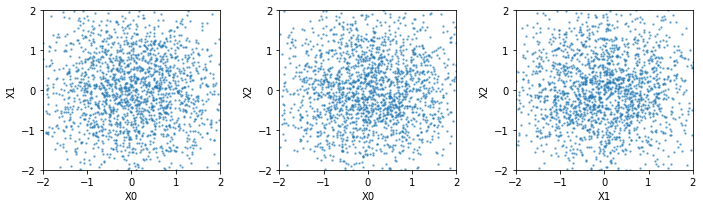

4.2061920166015625 4.309266090393066
4.206157684326172 4.309265613555908
4.206108570098877 4.309234142303467
4.2060394287109375 4.309174060821533
4.20598840713501 4.3091816902160645
4.205952167510986 4.309110164642334
4.205892086029053 4.309085369110107
4.2058186531066895 4.309079170227051
4.205763816833496 4.309009552001953
4.205677509307861 4.309010028839111


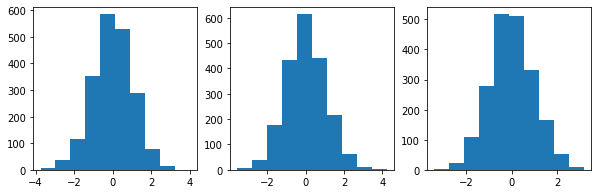

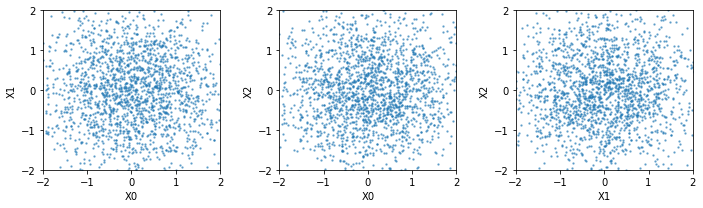

4.205621242523193 4.308931350708008
4.205563068389893 4.308923244476318
4.205470085144043 4.308877468109131
4.205440998077393 4.308876991271973
4.205317974090576 4.3088226318359375
4.205280303955078 4.308791637420654
4.205211162567139 4.308762550354004
4.20517635345459 4.308727741241455
4.205114364624023 4.308690547943115
4.205074787139893 4.308647632598877


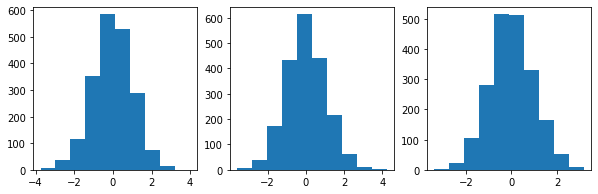

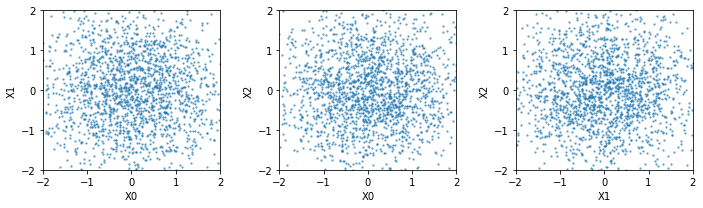

4.205000877380371 4.308640003204346
4.20497465133667 4.3086090087890625
4.204902172088623 4.308553695678711
4.204855442047119 4.308534622192383
4.2048115730285645 4.3084845542907715
4.204754829406738 4.308512210845947
4.204686641693115 4.30847692489624
4.204615116119385 4.3084564208984375
4.204538822174072 4.308412551879883
4.2045063972473145 4.308389186859131


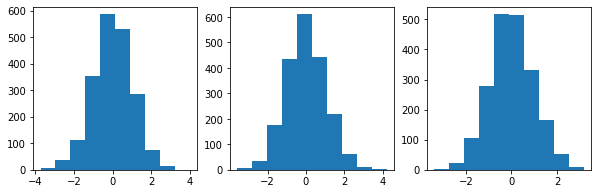

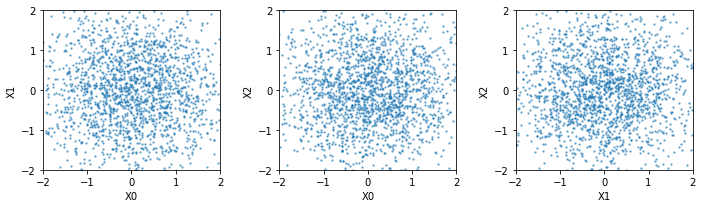

4.204456329345703 4.30835485458374
4.204405784606934 4.308331489562988
4.204349994659424 4.308307647705078
4.204311847686768 4.30823278427124
4.204269886016846 4.308255195617676


In [171]:
straf_train_loader = DataLoader(torch.Tensor(train_data).to(device), batch_size=1024)

val_losses = []

val_iter = 1
plot_iter = 10

loss_tot = 0
val_counter = 0

for epoch in range(1, 10000):
    for batch in straf_train_loader:
        straf_opt.zero_grad()
        z, jac = straf_model(batch)

        loss = straf_model.loss(z, jac)
        train_loss = loss.item()

        loss.backward()
        straf_opt.step()
    if epoch % val_iter == 0:
        with torch.no_grad():
            # Compute validation loss
            cur_x = torch.Tensor(val_data).to(device)
            z, jac = straf_model(cur_x)

            val_loss = straf_model.loss(z, jac).item()
            val_losses.append(val_loss)
            print(train_loss, val_loss)

            if epoch % plot_iter == 0:
                # 1D graphs
                f, ax = plt.subplots(1, 3, figsize=(10, 3))
                ax[0].hist(z[:, 0].cpu().numpy())
                ax[1].hist(z[:, 1].cpu().numpy())
                ax[2].hist(z[:, 2].cpu().numpy())
                plt.show()

            if len(val_losses) > 1 and val_loss > val_losses[-2]:
                val_counter += 1
                if val_counter > 5:
                    break

            if epoch % plot_iter == 0:
                if torch.is_tensor(z):
                    z = z.detach().cpu().numpy()
                viz_data(z)


[KstestResult(statistic=0.1925, pvalue=3.3306690738754696e-16),
 KstestResult(statistic=0.136, pvalue=3.876172993688698e-08),
 KstestResult(statistic=0.2311, pvalue=3.3306690738754696e-16)]

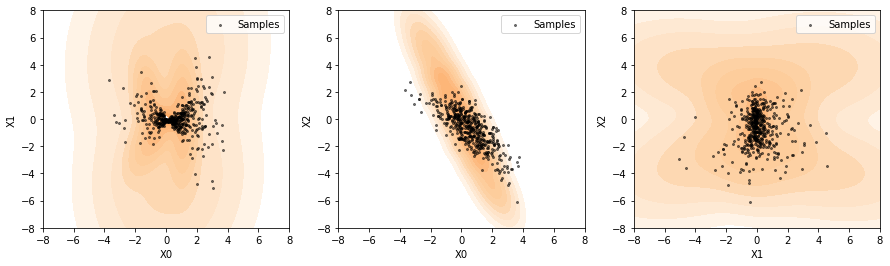

In [172]:
from scipy.stats import kstest

torch.manual_seed(2541)
z = torch.randn(500, 3).to(device)
straf_x_samp = straf_model.invert(z)
straf_x_samp = straf_x_samp.detach().cpu().numpy()

viz_err(straf_x_samp, true_dist, None)

[kstest(straf_x_samp[:, dim], true_dist[:, dim]) for dim in range(z.shape[1])]

Model Loss: 4.190885066986084


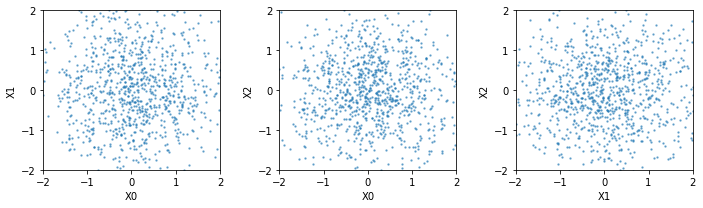

In [173]:
test_in = torch.Tensor(test_data).to(device)

z, jac = straf_model(test_in)

model_loss = straf_model.loss(z, jac).item()

print("Model Loss:", model_loss)

if torch.is_tensor(z):
    z = z.detach().cpu().numpy()

viz_data(z)

## DAG Model

In [10]:
dag_emb_net = [50] * 3 + [2]
dag_n_flows = 5

conditioner_type = DAGConditioner
conditioner_args = {
    "in_size": train_data.shape[1],
    "hidden": dag_emb_net[:-1],
    "out_size": dag_emb_net[-1],
    "hot_encoding": True,
    "soft_thresholding": False,
    "h_thresh": 0,
    "A_prior": true_A.clone(),
    "A_req_grad": False,
}

normalizer_type = AffineNormalizer
normalizer_args = {}

dag_model = buildFixedFCNormalizingFlow(dag_n_flows, conditioner_type, conditioner_args,
                                        normalizer_type, normalizer_args)
dag_model.to(device)
dag_opt = torch.optim.Adam(dag_model.parameters(), 1e-4, weight_decay=1e-5)

6.650843143463135 6.79927396774292
5.686612606048584 5.878169059753418
5.337954044342041 5.552484512329102
5.129558086395264 5.371645450592041
4.968713283538818 5.237987518310547
4.841867446899414 5.137443542480469
4.74625301361084 5.061048984527588
4.671034812927246 4.996248245239258
4.605836868286133 4.936826229095459
4.548433303833008 4.882916450500488


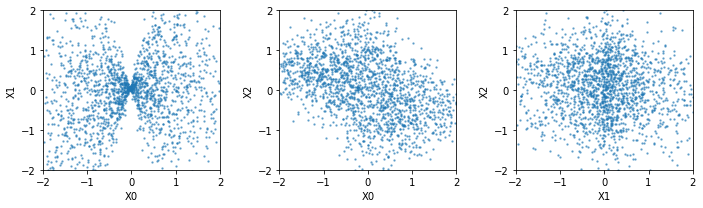

4.49533748626709 4.833327293395996
4.442313194274902 4.7863450050354
4.395707130432129 4.745482444763184
4.353893280029297 4.709705829620361
4.317902565002441 4.67898416519165
4.287364482879639 4.651812553405762
4.259007453918457 4.6277289390563965
4.233577251434326 4.606659412384033
4.211496353149414 4.588070869445801
4.192975044250488 4.571373462677002


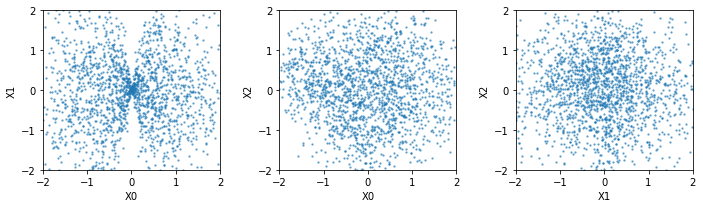

4.176414966583252 4.55643367767334
4.160844326019287 4.542813777923584
4.145932197570801 4.530482769012451
4.133313179016113 4.51913595199585
4.121541500091553 4.5088605880737305
4.111734390258789 4.499093055725098
4.102609634399414 4.49062442779541
4.0934834480285645 4.483145236968994
4.085964679718018 4.476397514343262
4.079863548278809 4.47052526473999


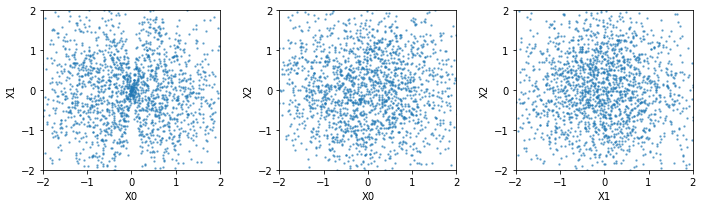

4.074921607971191 4.465379238128662
4.070451736450195 4.460686206817627
4.066296577453613 4.456305027008057
4.0626115798950195 4.452309608459473
4.059428691864014 4.448648452758789
4.056215763092041 4.445328235626221
4.052924156188965 4.442236423492432
4.050160884857178 4.4393744468688965
4.047493934631348 4.436814308166504
4.04496955871582 4.434357166290283


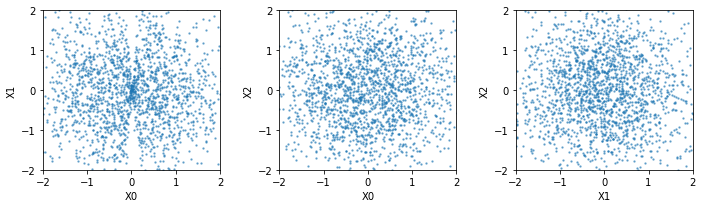

4.042154788970947 4.4319915771484375
4.039349555969238 4.429853916168213
4.037095069885254 4.427818775177002
4.034946918487549 4.425943374633789
4.032655239105225 4.424123764038086
4.030251502990723 4.422307968139648
4.0279541015625 4.420698165893555
4.025593280792236 4.4192328453063965
4.023406028747559 4.417829990386963
4.02189302444458 4.41654634475708


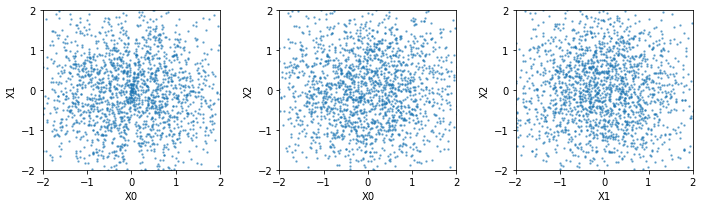

4.019697189331055 4.415297985076904
4.017709255218506 4.414105415344238
4.016164779663086 4.412927150726318
4.0149455070495605 4.411803722381592
4.012993812561035 4.410794258117676
4.011253833770752 4.409799098968506
4.009781837463379 4.408792018890381
4.007963180541992 4.407917022705078
4.006301403045654 4.407001495361328
4.0048298835754395 4.40617561340332


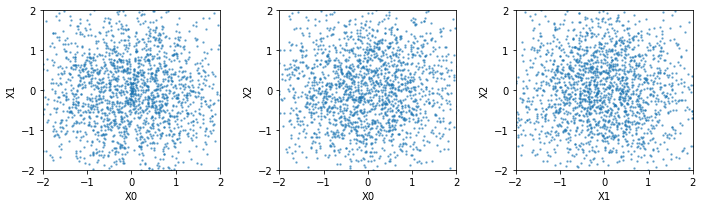

4.003273010253906 4.405346870422363
4.0020246505737305 4.404621124267578
4.001267433166504 4.4039306640625
4.000387191772461 4.40326452255249
3.9994149208068848 4.402594089508057
3.9987199306488037 4.401981830596924
3.997661828994751 4.40138053894043
3.9964232444763184 4.400783538818359
3.995725631713867 4.400249004364014
3.9947502613067627 4.399722576141357


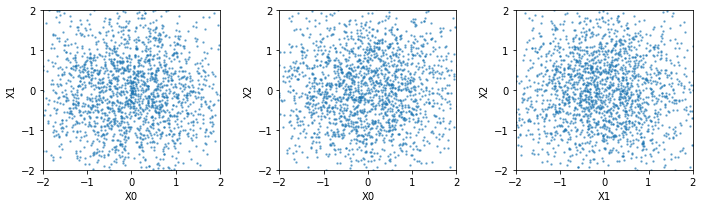

3.99345064163208 4.399237632751465
3.992537498474121 4.3987531661987305
3.99147367477417 4.398259162902832
3.9907307624816895 4.397789478302002
3.989306926727295 4.397359371185303
3.988950490951538 4.39695930480957
3.98769474029541 4.396492958068848
3.9876508712768555 4.396126747131348
3.986909866333008 4.395783424377441
3.9856953620910645 4.395376682281494


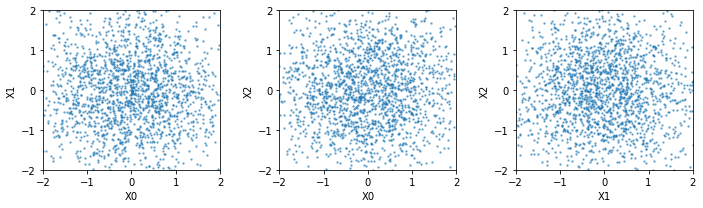

3.984968662261963 4.3949809074401855
3.984945774078369 4.394592761993408
3.9837594032287598 4.394204616546631
3.982741117477417 4.393854141235352
3.9823949337005615 4.39348840713501
3.981693744659424 4.393120288848877
3.981400489807129 4.3927836418151855
3.9805307388305664 4.392449855804443
3.9794483184814453 4.392116546630859
3.979243278503418 4.391806125640869


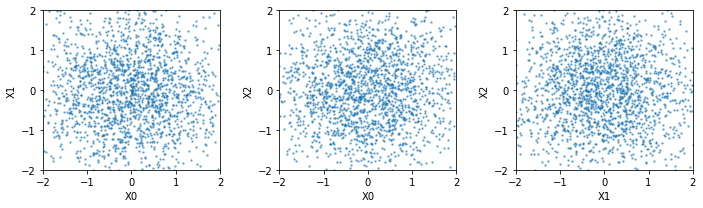

3.97805118560791 4.3914384841918945
3.9772722721099854 4.391115665435791
3.977139711380005 4.390824317932129
3.9766478538513184 4.390525817871094
3.9759914875030518 4.390203475952148
3.975146532058716 4.389946937561035
3.9742226600646973 4.389633655548096
3.9737415313720703 4.389357566833496
3.9729244709014893 4.389004230499268
3.973280429840088 4.388792991638184


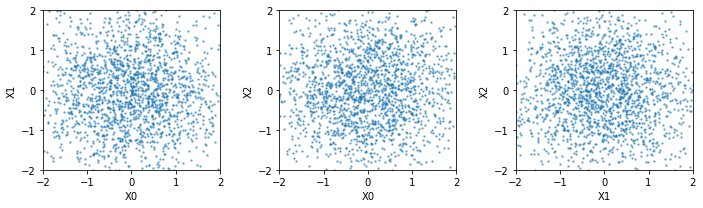

3.9720144271850586 4.388540267944336
3.9712319374084473 4.3882246017456055
3.970579147338867 4.388000011444092
3.969296932220459 4.38771915435791
3.969137668609619 4.387480735778809
3.968996047973633 4.387231826782227
3.9683728218078613 4.387020587921143
3.9676101207733154 4.38677453994751
3.9668161869049072 4.386547088623047
3.9664032459259033 4.3863301277160645


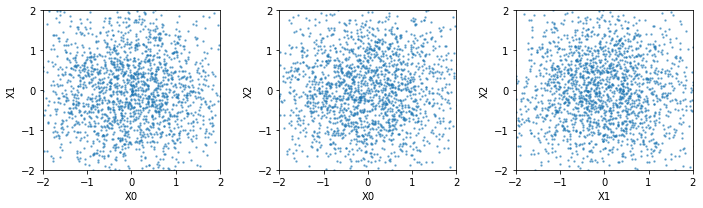

3.9655699729919434 4.386107921600342
3.966984987258911 4.3859543800354
3.964886426925659 4.385715961456299
3.964428186416626 4.385522842407227
3.963667392730713 4.385301113128662
3.9630749225616455 4.385083198547363
3.963412284851074 4.384856224060059
3.962371826171875 4.384634017944336
3.961369276046753 4.384439468383789
3.9618563652038574 4.3841776847839355


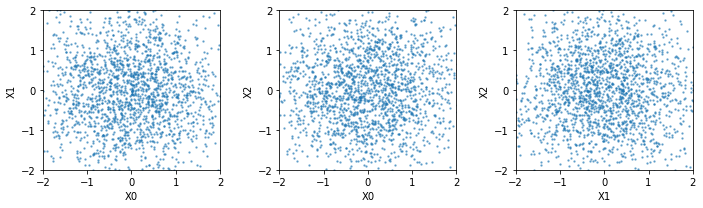

3.961144208908081 4.384003162384033
3.961355209350586 4.38385009765625
3.960028886795044 4.383629322052002
3.9588894844055176 4.383456230163574
3.9597244262695312 4.38330602645874
3.958861827850342 4.383136749267578
3.958256244659424 4.383007526397705
3.958002805709839 4.382781505584717
3.9577622413635254 4.382603645324707
3.9562597274780273 4.382441520690918


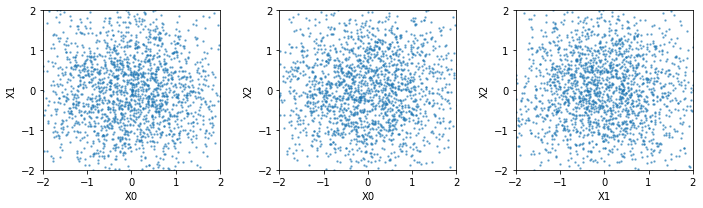

3.956120014190674 4.382261753082275
3.955629825592041 4.382078170776367
3.9548685550689697 4.3818888664245605
3.9553818702697754 4.381767749786377
3.9543468952178955 4.3816728591918945
3.9537365436553955 4.3814287185668945
3.9537534713745117 4.381285190582275
3.9537858963012695 4.381162166595459
3.952282667160034 4.381070137023926
3.951508045196533 4.380890846252441


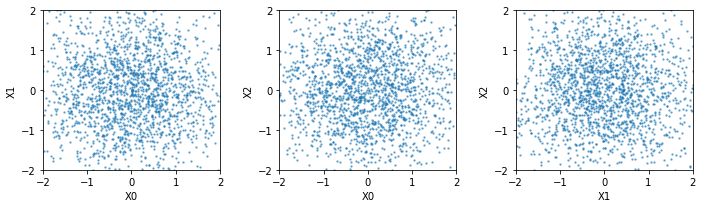

3.950861692428589 4.380712032318115
3.951993465423584 4.380580902099609
3.9497201442718506 4.380503177642822
3.94987154006958 4.380342483520508
3.9491634368896484 4.380175590515137
3.9499666690826416 4.380080699920654
3.9479176998138428 4.37997579574585
3.9483437538146973 4.379810333251953
3.9476490020751953 4.379670143127441
3.947277784347534 4.3795294761657715


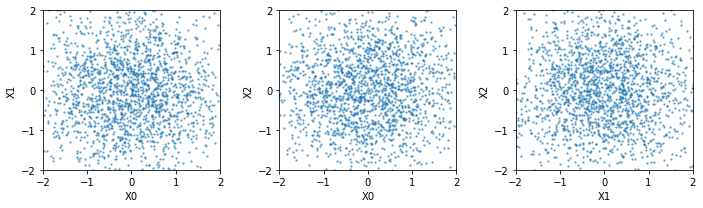

3.9476959705352783 4.379405498504639
3.946758270263672 4.379251003265381
3.9455485343933105 4.379122257232666
3.9452881813049316 4.379016876220703
3.9449172019958496 4.378880977630615
3.945798397064209 4.378754138946533
3.9440746307373047 4.378655433654785
3.944784641265869 4.3785176277160645
3.943359375 4.378443717956543
3.9427571296691895 4.378248691558838


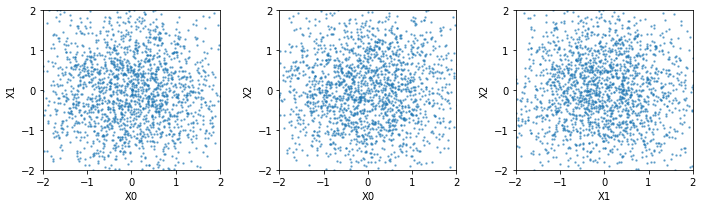

3.943601369857788 4.378194332122803
3.9435720443725586 4.378086566925049
3.942058801651001 4.377992630004883
3.9414753913879395 4.377838134765625
3.942796230316162 4.377790451049805
3.940694808959961 4.37765645980835
3.940549850463867 4.377527236938477
3.9408116340637207 4.377458095550537
3.940325975418091 4.377460956573486
3.940187454223633 4.377295017242432


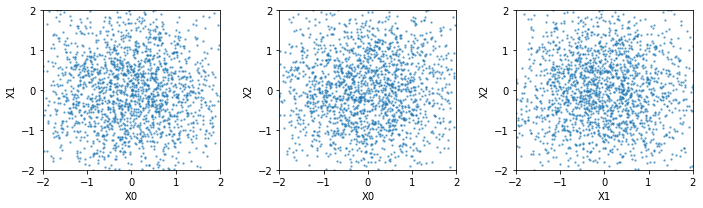

3.939641237258911 4.3771867752075195
3.939338207244873 4.377121448516846
3.938103199005127 4.376999378204346
3.9389872550964355 4.376963138580322
3.938047409057617 4.376791477203369
3.9378905296325684 4.376722812652588
3.9374444484710693 4.376615524291992
3.93780779838562 4.376525402069092
3.9369969367980957 4.376448631286621
3.9372658729553223 4.376328945159912


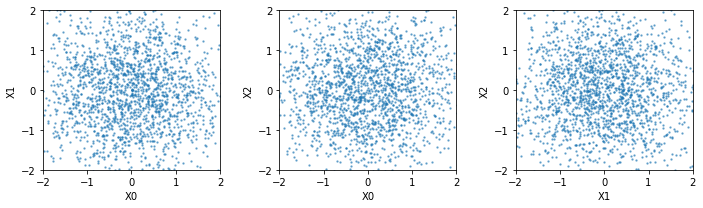

3.93703031539917 4.376262664794922
3.9366345405578613 4.376245021820068
3.936831474304199 4.376170635223389
3.9358091354370117 4.376058578491211
3.935133218765259 4.376005172729492
3.935698986053467 4.375952243804932
3.9353489875793457 4.375894069671631
3.9342994689941406 4.375791072845459
3.9352102279663086 4.375770568847656
3.9346046447753906 4.375697135925293


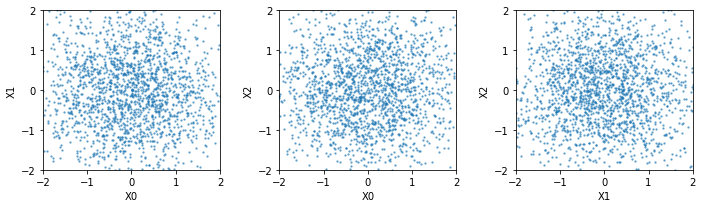

3.9340622425079346 4.3756103515625
3.933584213256836 4.375538349151611
3.9336225986480713 4.375486373901367
3.9328856468200684 4.3754730224609375
3.9328455924987793 4.375304698944092
3.9330739974975586 4.375301837921143
3.9328441619873047 4.375253200531006
3.9324512481689453 4.375141620635986
3.931457042694092 4.375116348266602
3.932278633117676 4.375056266784668


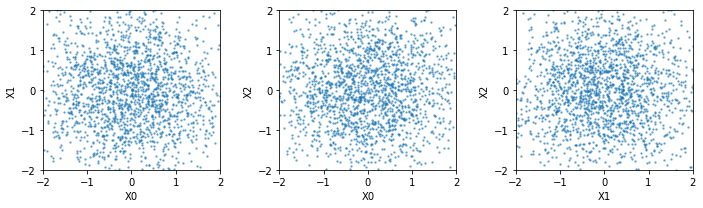

3.9319677352905273 4.375022888183594
3.931931972503662 4.375009059906006
3.931873321533203 4.374992847442627
3.9315285682678223 4.374906539916992
3.930548667907715 4.374830722808838
3.93125581741333 4.374705791473389
3.9306259155273438 4.374709129333496
3.9309158325195312 4.374691009521484
3.92984676361084 4.374677658081055
3.929802417755127 4.3746466636657715


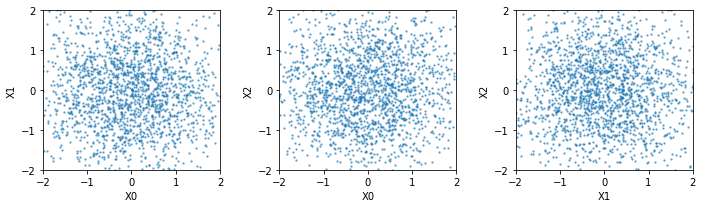

3.9293885231018066 4.374563694000244
3.929874897003174 4.374544143676758
3.929746150970459 4.374457359313965
3.9292376041412354 4.3744330406188965
3.9288952350616455 4.374396800994873
3.9280800819396973 4.3743510246276855
3.927931308746338 4.374288082122803
3.927964687347412 4.374244689941406
3.927947521209717 4.374151706695557
3.9276986122131348 4.374189853668213


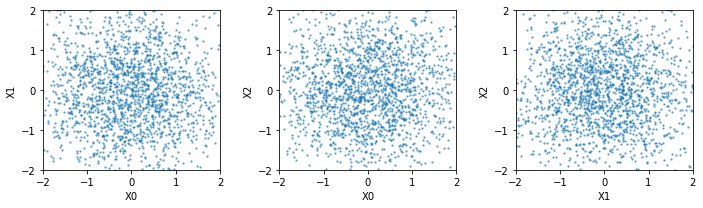

3.9269840717315674 4.374081134796143
3.927178382873535 4.37406063079834
3.9275197982788086 4.374005317687988
3.9269866943359375 4.373988151550293
3.9269936084747314 4.3739728927612305
3.92641544342041 4.373966217041016
3.9259824752807617 4.3739166259765625
3.92628812789917 4.373879432678223
3.925884962081909 4.3738226890563965
3.9262046813964844 4.373811721801758


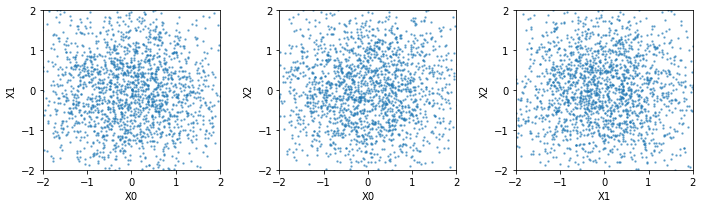

3.926177978515625 4.373772621154785
3.9252395629882812 4.3737688064575195
3.9253320693969727 4.373664379119873
3.925297737121582 4.373709201812744
3.9251532554626465 4.3736186027526855
3.925042152404785 4.373607158660889
3.924736976623535 4.373555660247803
3.9249343872070312 4.373561859130859
3.9243624210357666 4.373492240905762
3.924809694290161 4.373508930206299


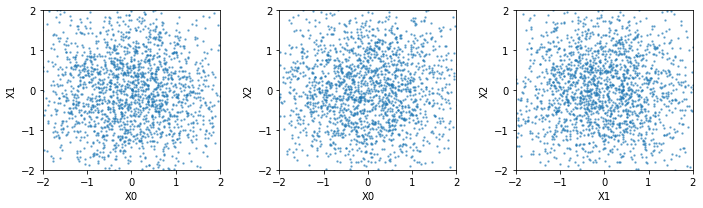

3.9239354133605957 4.37345027923584
3.9241461753845215 4.373423099517822
3.924309253692627 4.3734025955200195
3.922898292541504 4.3733367919921875
3.923243522644043 4.373321533203125
3.923666477203369 4.373379230499268
3.9230992794036865 4.373319625854492
3.9233973026275635 4.3733134269714355
3.922611713409424 4.373202323913574
3.923694610595703 4.373260498046875


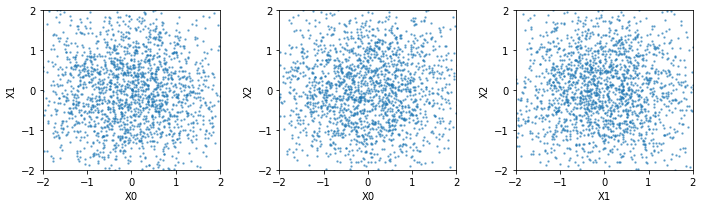

3.9227075576782227 4.373208522796631
3.922152042388916 4.373157978057861
3.9222512245178223 4.373143672943115
3.9223928451538086 4.3731536865234375
3.9215426445007324 4.3731369972229
3.9217944145202637 4.373118877410889
3.9215824604034424 4.373081684112549
3.921248197555542 4.373049736022949
3.921572208404541 4.37303352355957
3.921027421951294 4.373015880584717


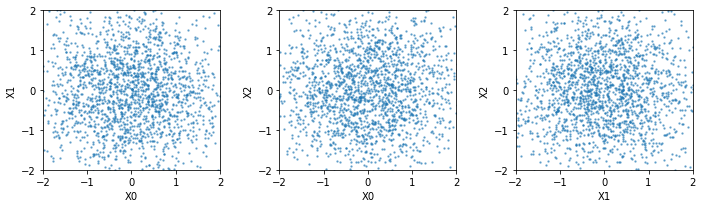

3.9210000038146973 4.3730316162109375
3.9207561016082764 4.372993469238281
3.920498847961426 4.3729658126831055
3.920487880706787 4.372928142547607
3.919661045074463 4.372856616973877
3.919827938079834 4.372899532318115
3.919978618621826 4.372878074645996
3.9200849533081055 4.3728556632995605
3.919938087463379 4.3728203773498535
3.920290231704712 4.3728718757629395


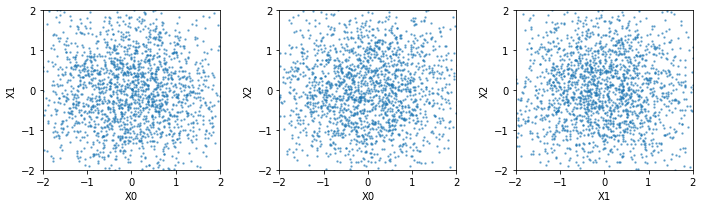

3.919264316558838 4.372790336608887
3.919633388519287 4.372779846191406
3.919314384460449 4.372743606567383
3.918869972229004 4.372700214385986
3.918846368789673 4.37266731262207
3.9189600944519043 4.372697353363037
3.9189043045043945 4.37266731262207
3.918794870376587 4.372673034667969
3.918766498565674 4.372649669647217
3.918449640274048 4.372644901275635


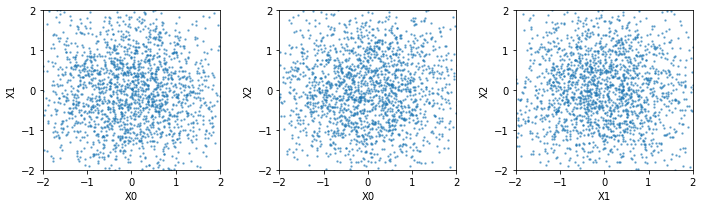

3.918541431427002 4.372594356536865
3.918750762939453 4.372679710388184
3.9176859855651855 4.372542381286621
3.9179863929748535 4.372564315795898
3.917750597000122 4.372511386871338
3.918212890625 4.372502326965332
3.9178273677825928 4.372468948364258
3.9179797172546387 4.372509956359863
3.9175944328308105 4.372447967529297
3.917935371398926 4.372493267059326


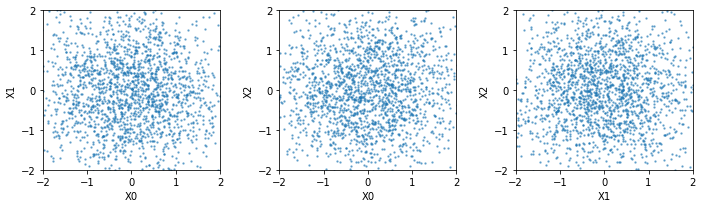

3.917191982269287 4.372418403625488
3.917591094970703 4.3724775314331055
3.917310953140259 4.372410774230957
3.917116641998291 4.372452259063721
3.916963815689087 4.3723297119140625
3.917837142944336 4.372381210327148
3.917060375213623 4.372340202331543
3.9174814224243164 4.372348785400391
3.916682481765747 4.372311115264893
3.9164204597473145 4.372238636016846


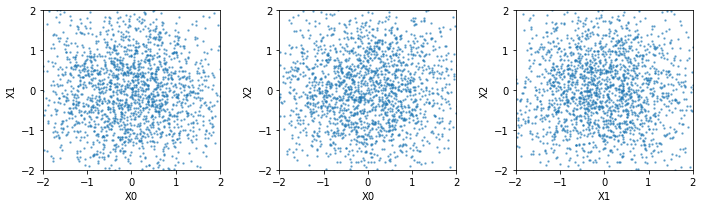

3.9165568351745605 4.372280597686768
3.916666030883789 4.37228536605835
3.916290283203125 4.372297763824463
3.9158835411071777 4.372246265411377
3.916724681854248 4.372232437133789
3.915820837020874 4.3721842765808105
3.91628360748291 4.3722028732299805
3.915947914123535 4.3721723556518555
3.9159207344055176 4.372185707092285
3.91597318649292 4.372149467468262


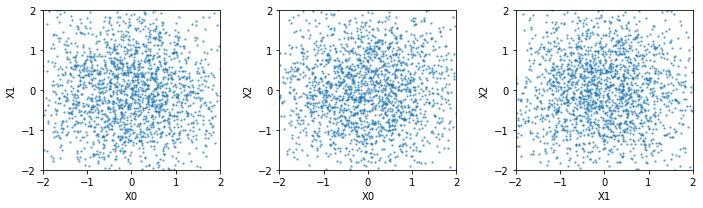

3.915759563446045 4.372137069702148
3.9156863689422607 4.3720831871032715
3.915733814239502 4.372103691101074
3.915527582168579 4.372102737426758
3.9157893657684326 4.37205696105957
3.915632963180542 4.372003078460693
3.915092945098877 4.371982097625732
3.9150888919830322 4.37197208404541
3.915741443634033 4.37197208404541
3.915039539337158 4.371933460235596


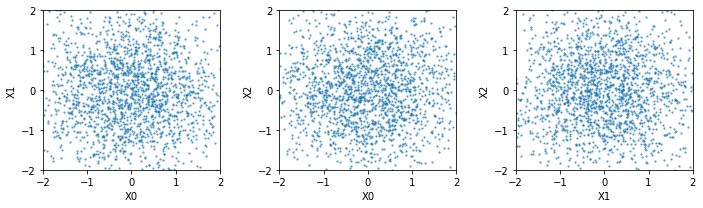

3.9153356552124023 4.371921062469482
3.9152112007141113 4.371940612792969
3.9149155616760254 4.371850490570068
3.9147777557373047 4.371879577636719
3.9157958030700684 4.371883869171143
3.914828300476074 4.371885299682617
3.9154603481292725 4.371881484985352
3.914447069168091 4.3718438148498535
3.915163278579712 4.371824741363525
3.914618968963623 4.371817111968994


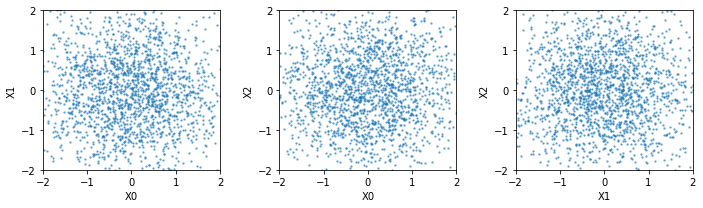

3.9144115447998047 4.371779918670654
3.914323329925537 4.371737003326416
3.9146957397460938 4.371754169464111
3.9142961502075195 4.371764659881592
3.914536952972412 4.371723651885986
3.914156675338745 4.371752738952637
3.91386079788208 4.37170934677124
3.9141123294830322 4.371664524078369
3.9144303798675537 4.371667861938477
3.913773536682129 4.371684551239014


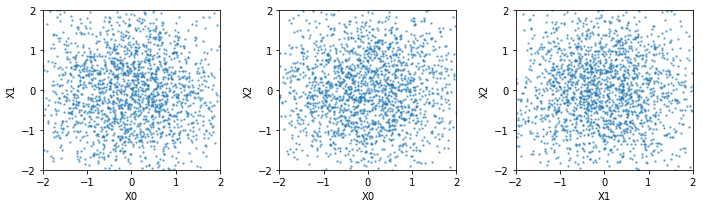

3.9138078689575195 4.371651649475098
3.9140098094940186 4.371666431427002
3.9141883850097656 4.371646881103516
3.913583278656006 4.3715996742248535
3.9138660430908203 4.3716206550598145
3.9136195182800293 4.371603488922119
3.9140989780426025 4.371628284454346
3.9130423069000244 4.371585369110107
3.913576126098633 4.371598720550537
3.913696050643921 4.37159538269043


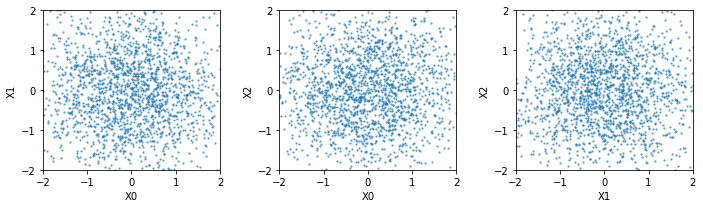

3.913546323776245 4.3715667724609375
3.9137401580810547 4.371617317199707
3.9132497310638428 4.371553421020508
3.9137396812438965 4.371592998504639
3.9131641387939453 4.371508598327637
3.9131078720092773 4.371557235717773
3.912630558013916 4.371527194976807
3.9133715629577637 4.3715715408325195
3.913006544113159 4.371527671813965
3.9127559661865234 4.371523857116699


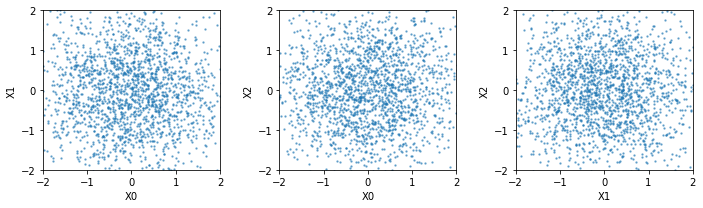

3.9130501747131348 4.371548175811768
3.912872314453125 4.371514797210693
3.912672758102417 4.371492385864258
3.912975311279297 4.371534824371338
3.912280321121216 4.371476650238037
3.9130139350891113 4.371525764465332
3.912201404571533 4.371452331542969
3.913254737854004 4.371445655822754
3.912454128265381 4.371459484100342
3.912626266479492 4.3714728355407715


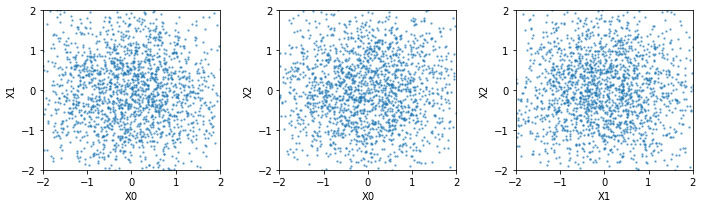

3.9125967025756836 4.371419906616211
3.912961483001709 4.371439456939697
3.912527084350586 4.3714213371276855
3.9124374389648438 4.371427059173584
3.9124717712402344 4.371447563171387
3.9121928215026855 4.371403217315674
3.9123477935791016 4.371408462524414
3.912226438522339 4.37139368057251
3.911891460418701 4.3713908195495605
3.9125051498413086 4.371366500854492


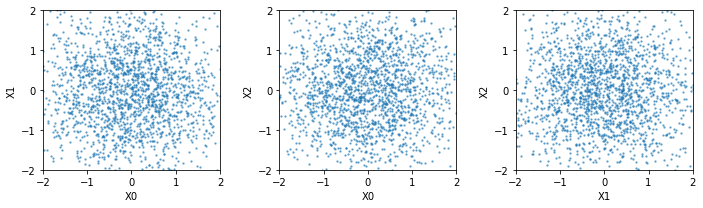

3.912091016769409 4.371330261230469
3.912438154220581 4.371391773223877
3.912057638168335 4.371388912200928
3.912062168121338 4.371351718902588
3.9126415252685547 4.371337413787842
3.912113666534424 4.371382236480713
3.912114143371582 4.3712873458862305
3.9122159481048584 4.371349811553955
3.9121549129486084 4.371352195739746
3.912041664123535 4.371336936950684


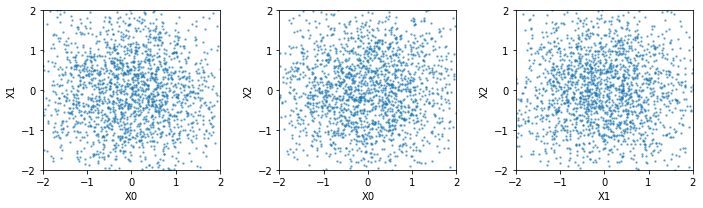

3.911527156829834 4.3713202476501465
3.9120659828186035 4.371303081512451
3.911489486694336 4.371312618255615
3.911956310272217 4.371314525604248
3.91229248046875 4.371303081512451
3.9118223190307617 4.371321678161621
3.911616325378418 4.371275424957275
3.9123682975769043 4.371328353881836
3.9114863872528076 4.371284484863281
3.9117140769958496 4.371265888214111


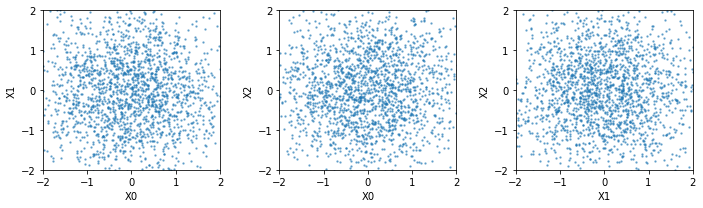

3.9121406078338623 4.371275424957275
3.911367416381836 4.371252059936523
3.9117562770843506 4.371256351470947
3.911827564239502 4.371246337890625
3.9117250442504883 4.371289253234863
3.9113850593566895 4.371245384216309
3.9120490550994873 4.371254920959473
3.9115848541259766 4.37123966217041
3.911315441131592 4.37125301361084
3.9119648933410645 4.371214866638184


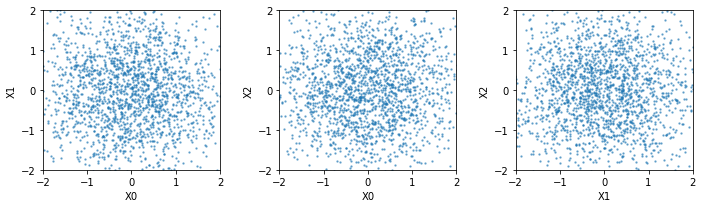

3.910888195037842 4.371232509613037
3.911712884902954 4.371210098266602
3.911414861679077 4.371227741241455
3.911673069000244 4.3711838722229
3.9110465049743652 4.371190547943115
3.911823272705078 4.371253967285156
3.91115403175354 4.37123441696167
3.9113829135894775 4.371216297149658
3.911125421524048 4.371161460876465
3.9109630584716797 4.37120246887207


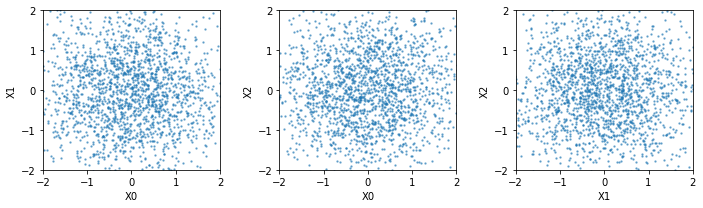

3.9106099605560303 4.371147632598877
3.911388874053955 4.371159076690674
3.9112167358398438 4.371151447296143
3.910890579223633 4.371187686920166
3.9109487533569336 4.371148586273193
3.9112329483032227 4.3711347579956055
3.910696029663086 4.371144771575928
3.9114246368408203 4.3711724281311035
3.911141872406006 4.371108055114746
3.911210060119629 4.371149063110352


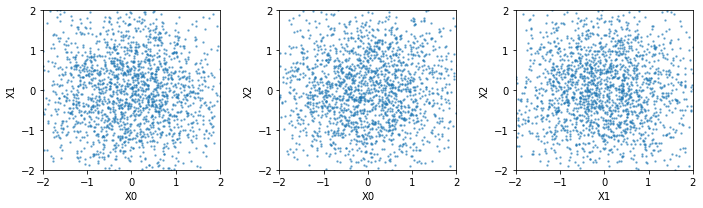

3.910717487335205 4.371053695678711
3.9112441539764404 4.371160507202148
3.9114603996276855 4.37110710144043
3.9109604358673096 4.371114253997803
3.9107115268707275 4.371118545532227
3.9111592769622803 4.3711395263671875
3.9107208251953125 4.371090412139893
3.9110214710235596 4.3710479736328125
3.9106850624084473 4.371068477630615
3.9110307693481445 4.371102809906006


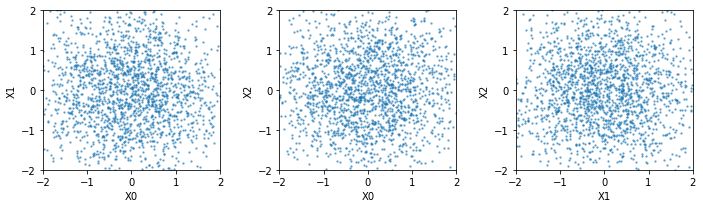

3.9109253883361816 4.371039867401123
3.9110727310180664 4.371045112609863
3.9104576110839844 4.371029853820801
3.910372257232666 4.371016502380371
3.911457061767578 4.371064186096191
3.9105117321014404 4.371081352233887
3.9103755950927734 4.370994567871094
3.9113099575042725 4.371073246002197
3.9102623462677 4.371007442474365
3.9107823371887207 4.370993137359619


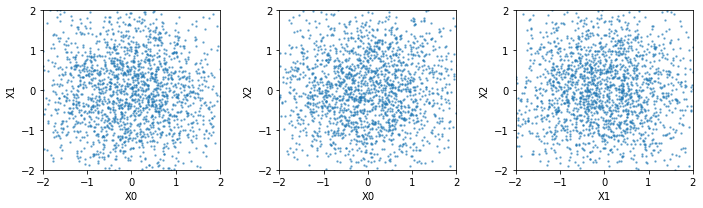

3.9108004570007324 4.371041297912598
3.910297393798828 4.3710246086120605
3.9105610847473145 4.370965957641602
3.910548210144043 4.370997428894043
3.910804271697998 4.371021747589111
3.9102625846862793 4.370974063873291
3.9107789993286133 4.370970726013184
3.9104514122009277 4.3709306716918945
3.9103870391845703 4.370950222015381
3.9106764793395996 4.370960712432861


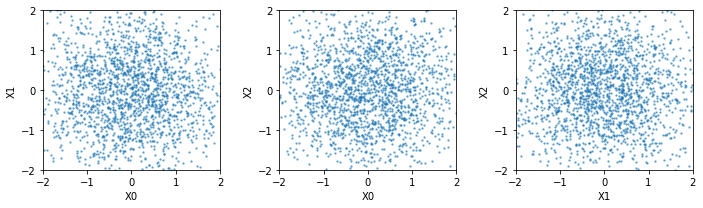

3.91007661819458 4.370901107788086
3.9105000495910645 4.370915412902832
3.9107792377471924 4.370903015136719
3.9104580879211426 4.370962619781494
3.910560131072998 4.370888710021973
3.9104394912719727 4.370963096618652
3.910094738006592 4.370906352996826
3.91015625 4.370913028717041
3.911043167114258 4.370934963226318
3.910489082336426 4.370849609375


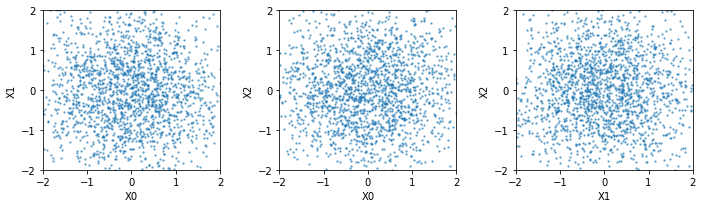

3.9103081226348877 4.370841026306152
3.9103002548217773 4.370895862579346
3.910489082336426 4.370882034301758
3.9103240966796875 4.370790481567383
3.9105658531188965 4.370859622955322
3.9100306034088135 4.370795249938965
3.910485029220581 4.370821475982666
3.9107794761657715 4.3708391189575195
3.909916877746582 4.370781421661377
3.909968852996826 4.370751857757568


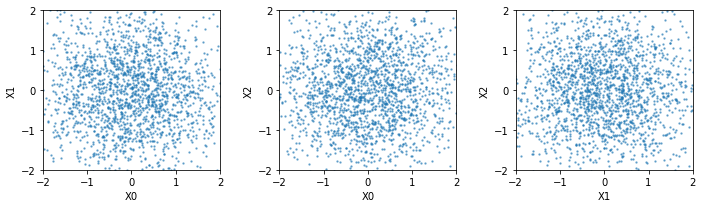

3.910398483276367 4.370858669281006
3.9098949432373047 4.37078857421875
3.909990072250366 4.370834827423096
3.909947395324707 4.370819568634033
3.910195827484131 4.370782375335693
3.909792423248291 4.370797157287598
3.910353422164917 4.3708672523498535
3.909369945526123 4.37080192565918
3.9102189540863037 4.370831489562988
3.9098660945892334 4.370800971984863


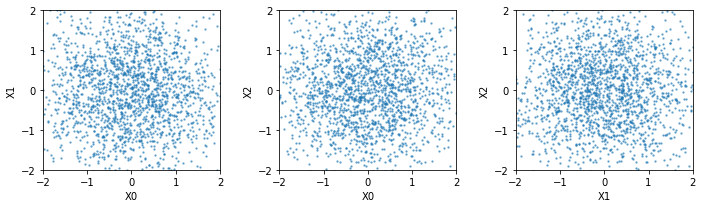

3.909820795059204 4.370763778686523
3.910062789916992 4.370806694030762
3.909912347793579 4.370821475982666
3.910414695739746 4.370807647705078
3.9096016883850098 4.370780944824219
3.909874439239502 4.370768070220947
3.9098334312438965 4.370802879333496
3.9096179008483887 4.370729923248291
3.9096462726593018 4.370789527893066
3.9093549251556396 4.370757102966309


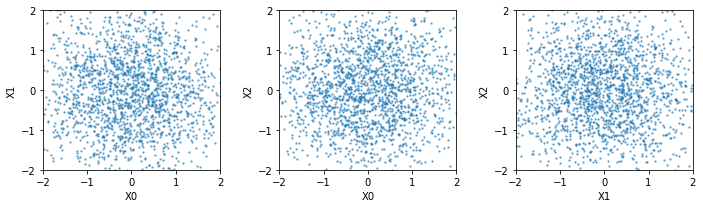

3.909788131713867 4.370721817016602
3.9098849296569824 4.370790481567383
3.909390926361084 4.37075138092041
3.909878730773926 4.3707451820373535
3.9095511436462402 4.370783805847168
3.909322738647461 4.370713233947754
3.909726142883301 4.370772838592529
3.9096174240112305 4.370725631713867
3.9092636108398438 4.370699882507324
3.909586191177368 4.370728492736816


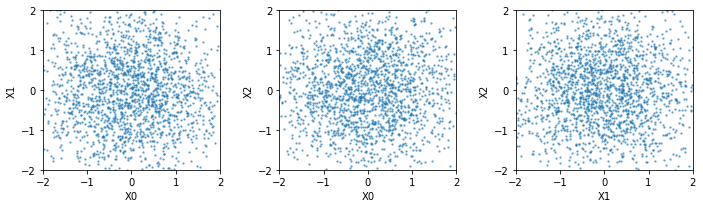

3.9093475341796875 4.370728492736816
3.9103128910064697 4.370751857757568
3.9095544815063477 4.370728492736816
3.909851312637329 4.370702743530273
3.909125804901123 4.37073278427124
3.9095520973205566 4.37071418762207
3.9093668460845947 4.370747089385986
3.9101200103759766 4.370758056640625
3.9091854095458984 4.370735168457031
3.910034656524658 4.370781898498535


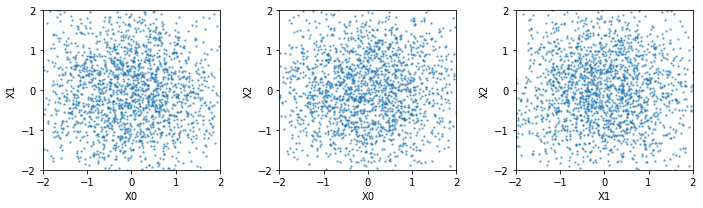

3.909264326095581 4.370731830596924
3.910036563873291 4.370716571807861
3.9095044136047363 4.370747089385986
3.909694194793701 4.370725631713867
3.9093589782714844 4.370690822601318
3.90994930267334 4.370680809020996
3.9095020294189453 4.370690822601318
3.9096298217773438 4.370672702789307
3.9095211029052734 4.370701313018799
3.9094533920288086 4.370684623718262


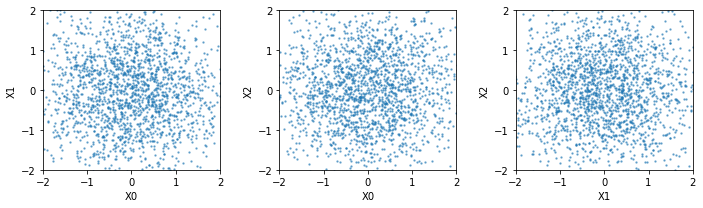

3.9094505310058594 4.370699882507324
3.9093334674835205 4.370664119720459
3.9100847244262695 4.370675086975098
3.9093010425567627 4.370645999908447


KeyboardInterrupt: 

In [12]:
val_losses = []
val_iter = 1
plot_iter = 10

dag_train_loader = DataLoader(torch.Tensor(train_data).to(device), batch_size=512)

for epoch in range(1, 20000):
    for batch in dag_train_loader:
        dag_opt.zero_grad()
        z, jac = dag_model(batch)

        loss = dag_model.loss(z, jac)
        train_loss = loss.item()

        loss.backward()
        dag_opt.step()

    if epoch % val_iter == 0:
        with torch.no_grad():
            # Compute validation loss
            cur_x = torch.Tensor(val_data).to(device)
            z, jac = dag_model(cur_x)
            val_loss = dag_model.loss(z, jac).item()

            if len(val_losses) > 0 and val_loss > val_losses[-1]:
                pass

            val_losses.append(val_loss)

            print(train_loss, val_loss)
            if epoch % plot_iter == 0:
                if torch.is_tensor(z):
                    z = z.detach().cpu().numpy()
                viz_data(z)
    dag_opt.step()

NameError: name 'kstest' is not defined

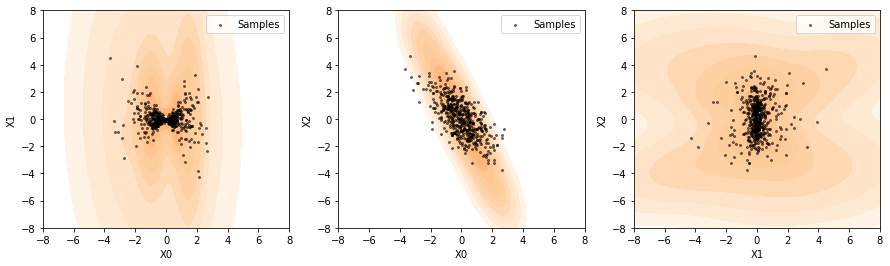

In [13]:
torch.manual_seed(2541)
z = torch.randn(500, 3).to(device)
dag_samp_x = dag_model.invert(z)
dag_samp_x = dag_samp_x.detach().cpu().numpy()

viz_err(dag_samp_x, true_dist, None)

[kstest(dag_samp_x[:, dim], true_dist[:, dim]) for dim in range(z.shape[1])]

Model Loss: 4.2705254554748535


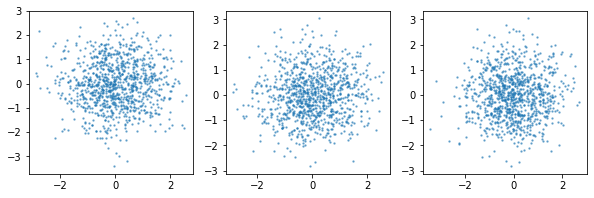

In [14]:
test_in = torch.Tensor(test_data).to(device)
z, jac = dag_model(test_in)
model_loss = dag_model.loss(z, jac).item()


print("Model Loss:", model_loss)

if torch.is_tensor(z):
    z = z.detach().cpu().numpy()

f, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].scatter(z[:, 0], z[:, 1], alpha=0.5, s=2)
ax[1].scatter(z[:, 0], z[:, 2], alpha=0.5, s=2)
ax[2].scatter(z[:, 1], z[:, 2], alpha=0.5, s=2)
plt.show()